## Simplyfied Replication of Storeygard (2016) 

In this assignment you have to generate the (simplyfied) final dataset used in **"Farther on down the road: transport costs, trade and urban growth"** (2016) Review of Economic Studies 83(3): 1263-1295. For this assignment, we are going to focus on **Tanzania** for the year **1992** and **2013**.

The final dataset (6 columns, 148 raws) should contained:
   - 74 Tanzanian city names (repeated twice for 1992 and 2013)
   - city populations (same value for 1992 and 2013)
   - a column for the year (1992 and 2013)
   - light values in both years (1992 and 2013)
   - oil prices in both years (1992 and 2013) 
   - distance to the primary city (same value for 1992 and 2013)

The objective is to use the geoprocessing tools and routines seen in class to solve the intermediate steps needed to assemble the final dataset. 

We have organized the assigment into 6 blocks:

1. Identify Tanzanian Cities
2. Compute total light emitted by each city in 1992 and 2013
3. Identify Tanzania's primary city
4. Create a routable road network
5. Find optimal paths between cities
6. Build the final dataset

Each section and subsection provide a detailed explanation of

- Inputs: shapefiles, raster
- Task objective and description
- Output

We are providing the packages we exepect you to use as well as the Coordinate Reference Systems.

Good luck!


In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import rasterio
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
from shapely.ops import nearest_points
from shapely.geometry import LineString, Point
import networkx as nx

In [3]:
# Defining Coordinate Reference System to use throughout the whole notebook
wgs84_crs = CRS.from_string('EPSG:4326') # WGS 1984
aeaa_crs = CRS.from_string("esri:102022") # albers equal area africa crs
aedc_crs = CRS.from_string("esri:102023") # Africa equidistant conic

# 1. Identify Tanzanian cities

The unit of observations is the city. Later on, we would to like to calculate average luminosity in both 1992 and 2013 for each city. To do that we need to have a polygon associated with each city. We need to find a way to assign a city name to its corresponding polygon.

- We have provided point locations of cities around the world (`citypop_v4_latlons.csv`) and their maximal night lights extents (`city_extents.shp`)

- Write code to identify, in Tanzania, light extents with known cities and discard light extends that cannot be identified with a city




In [4]:
cities = pd.read_csv('../data/cleaned/cities/citypop_v4_latlons.csv')
cities = gpd.GeoDataFrame(cities[cities.iso3v10=='TZA'], 
                          geometry = gpd.points_from_xy(cities[cities.iso3v10=='TZA']['lon'], 
                                                        cities[cities.iso3v10=='TZA']['lat']), 
                          crs = wgs84_crs)[['name', 'pop', 'geometry']].reset_index(drop=True).copy()
cities = cities.to_crs(aedc_crs)
cities['pop'] = cities['pop'].str.replace(',', '').astype('int')

light_polys = gpd.read_file('../data/cleaned/city_extents/city_extents.shp').to_crs(aedc_crs)
sjpts = gpd.sjoin_nearest(cities, light_polys, how="left", distance_col="sjdist")
sjpts['sjdist_km'] = sjpts.sjdist/1000
sjpts['maxpop'] = sjpts.groupby('FID')['pop'].transform('max')
# discard points distant more than 5km from a lights polygon and those with population not equal
# to the population of the largest city joined to a lights polygon
sjpts = sjpts[(sjpts.sjdist_km<=5) & (sjpts['pop']==sjpts['maxpop'])][['name', 'pop', 'FID', 'geometry']].reset_index(drop=True).to_crs(wgs84_crs).copy()
lights_cities = pd.merge(light_polys, sjpts.drop('geometry', axis=1), on=['FID'], how='inner').to_crs(wgs84_crs)

# 2. Compute total light emitted by each city in 1992 and 2013

Now that you manage to assign each city point to a polygon, your task is to calculate the average luminosity level for each polygon for the years 1992 and 2013.

- We have provided raster data of nighttime lights in Tanzania for 1992 and 2013 (`tza_lights_1992.tif` and `tza_lights_2013.tif`). 

- Combine them with the identified city extents above to compute total light emitted by each city in both years

- As a sanity check, make scatterplots of population against night lights (use log scale for better results). Hint: the two should be positevely correlated!

In [5]:
lights_1992 = rasterio.open('../data/cleaned/lights/tza_lights_1992.tif')
lights_2013 = rasterio.open('../data/cleaned/lights/tza_lights_2013.tif')
zs92 = zonal_stats(lights_cities, 
                   lights_1992.read(1).astype(float), 
                   affine=lights_1992.profile['transform'], 
                   stats=['sum'], 
                   nodata=np.nan, 
                   all_touched=True)
zs13 = zonal_stats(lights_cities, 
                   lights_2013.read(1).astype(float), 
                   affine=lights_2013.profile['transform'], 
                   stats=['sum'], 
                   nodata=np.nan, 
                   all_touched=True)
lights_cities['lights92'] = [x['sum'] for x in zs92]
lights_cities['lights13'] = [x['sum'] for x in zs13]

Please make scatterplots of population against night lights (in log scale) below. 

C:\Users\tregan\Miniconda3\envs\GIS2022\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


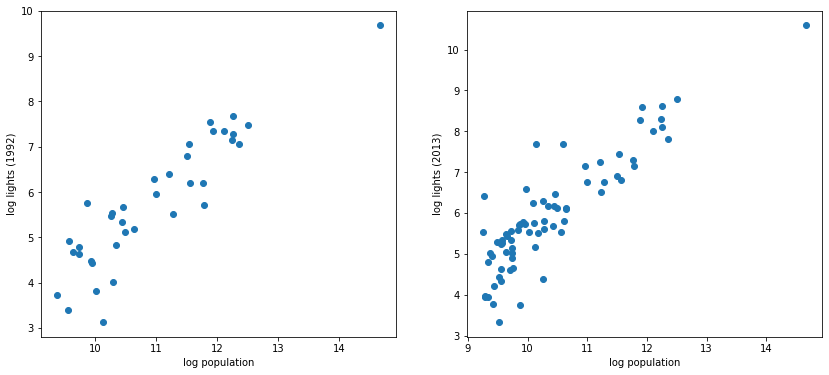

In [6]:
f, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].scatter(np.log(lights_cities['pop']), np.log(lights_cities['lights92']))
ax[1].scatter(np.log(lights_cities['pop']), np.log(lights_cities['lights13']))
ax[0].set_xlabel('log population')
ax[1].set_xlabel('log population')
ax[0].set_ylabel('log lights (1992)')
ax[1].set_ylabel('log lights (2013)')
plt.show(f)

# 3. Identify Tanzania's primary city

To make things simple, we call the primary city the one with the largest population. 

- Find the primary city.

- Plot the primary city with one color
- Plot all cities except the primary with a different color

- Add the outline of Tanzania to the plot (this is available in the file `tza_poly.shp` we have provided for you)

In [7]:
tza_poly = gpd.read_file('../data/cleaned/tza_poly/tza_polygon.shp')
sjpts[sjpts['pop'] == sjpts['pop'].max()]

,name,pop,FID,geometry
9,Dar es Salaam,2339910,167.0,POINT (39.28555 -6.81833)


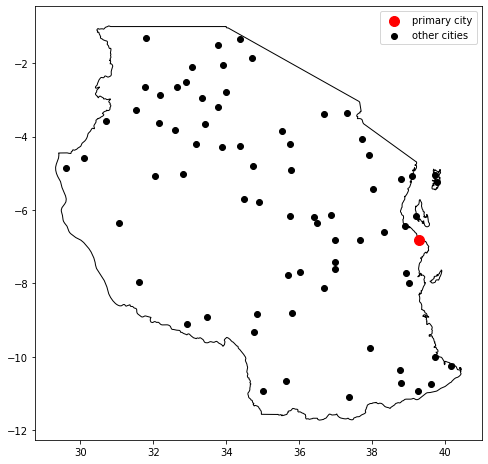

In [8]:
f, ax = plt.subplots(1,1, figsize=(8,8))
tza_poly.plot(ax=ax, color='white', edgecolor='black')
sjpts[sjpts['name'] == 'Dar es Salaam'].plot(ax=ax, color='r', markersize=100, label='primary city')
sjpts[sjpts['name'] != 'Dar es Salaam'].plot(ax=ax, color='k', label='other cities')
ax.legend()
plt.show(f)

# 4. Create a routable road network

As part of the identification stratey in Storeygard (2016), we need to compute the distance between each city and the primary city following the road network. In this section we will prepare the network, in section 5 we will solve it with the Djkstra's algorithm for the least costly path. 

The network should have the following elements: i) city points (as nodes), ii) roads (as edges), iii) connectors from city to roads (as edges)

- Using the file `roads.shp` we have provided for you as well as the point locations of identified cities in Section 1, create a network dataset that you can use to find shortest paths

- While this is somewhat involved, you have seen this exact procedure in the lecture on Donaldson and Hornbeck's paper on the American railroad. The steps we show there are what is needed here: you just need to adapt the code to fit the inputs for this application!

- For the costs, you can assume the following parameters (these relative costs are made up):
    - `cost_per_km_paved` = 1
    - `cost_per_km_unpaved` = 4
    
- For the connector pieces connecting city points to the road network, you can assume that they are paved

## 4.1 Create Road connectors to the cities points

In this subsection, you will generate the connectors from the cities to the closest road segment

In [10]:
roads = gpd.read_file('../data/cleaned/roads/roads.shp').to_crs(aedc_crs)
roads["adm0"]=1
dissolved_roads = roads.dissolve(by='adm0').geometry
del roads['adm0']

sjpts = sjpts.to_crs(aedc_crs)
sjpts['closest_point_on_roads'] = sjpts.apply(lambda x: nearest_points(dissolved_roads.geometry[1],
                                              x['geometry'])[0], axis=1)
# sjpts = sjpts.to_crs(wgs84_crs)

connectors_roads = sjpts.copy()
connectors_roads['geometry'] = connectors_roads.apply(lambda x: LineString([x['geometry'], x['closest_point_on_roads']]), axis=1)

sjpts = sjpts[['name', 'pop', 'FID', 'geometry']].copy()
connectors_roads = connectors_roads[['FID', 'geometry']].copy()

C:\Users\tregan\Miniconda3\envs\GIS2022\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\tregan\Miniconda3\envs\GIS2022\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


## 4.2 Deal with connectivity issues

As discussed in class, drawing the connectors is not sufficient to ensure full connectivity due to numerical precision. 

- Rescale the connectors by a small factor. Hint: There is one city connector that needs an extra large rescaling!


In [12]:
connectors_roads_scaled = connectors_roads.copy()
connectors_roads_scaled['geometry'] = connectors_roads_scaled.geometry.scale(xfact = 1.00001, yfact = 1.00001)
# Mtwara requires special treatment because its connector is very short and scaling it by 1.00001 is not enough for it to reach the road
connectors_roads_scaled.loc[connectors_roads_scaled.FID==227, 'geometry'] = (
    connectors_roads_scaled.loc[connectors_roads_scaled.FID==227, 'geometry'].scale(xfact = 1.05, yfact = 1.05) 
)

connectors_roads_scaled

,FID,geometry
0,58.0,"LINESTRING (1209274.472 -376163.652, 1209286.9..."
1,83.0,"LINESTRING (1112237.975 -468319.357, 1111997.5..."
2,153.0,"LINESTRING (1436141.341 -716769.688, 1436484.4..."
3,25.0,"LINESTRING (929815.441 -311321.882, 929724.324..."
4,3.0,"LINESTRING (704437.880 -146659.416, 704342.331..."
...,...,...
69,104.0,"LINESTRING (728887.328 -561251.329, 729082.490..."
70,46.0,"LINESTRING (676183.716 -362199.750, 679630.330..."
71,213.0,"LINESTRING (819076.784 -1008837.322, 818986.34..."
72,102.0,"LINESTRING (1522112.583 -564646.532, 1523022.5..."


Remember that after you applied the rescaling you also need to snap the cities' location to the rescaled connectors. This is achieved by the function above

In [13]:
def snap_points_to_modified_connectors(points_gdf, connectors_gdf):
    
    out = points_gdf.copy()
    
    for index, row in points_gdf.iterrows():
        
        tmp_gdf = connectors_gdf.copy()
        tmp_gdf['distance'] = tmp_gdf.distance(row['geometry'])
        closest_geom = list(tmp_gdf.sort_values('distance')['geometry'])[0]
        closest_pts = [Point(coords) for coords in closest_geom.coords]
        dists = [row['geometry'].distance(x) for x in closest_pts]
        minimum = min(dists)
        minimum_index = [i for i, j in enumerate(dists) if j == minimum][0]      
        out.loc[index, 'geometry'] = closest_pts[minimum_index]
        
    return out

Use the function above, to snap the identified city to the rescale connectors

In [14]:
modified_centroids = snap_points_to_modified_connectors(sjpts, connectors_roads_scaled)

## 4.3 Join roads and connectors

Now you can join the roads and the rescaled connectors to finalize the construction of your network edges

In [15]:
roads['transport_type'] = roads['surface']
del roads['surface']
connectors_roads_scaled['transport_type'] = 'paved'

joined_scaled = pd.concat([roads, connectors_roads_scaled])

uun_joined_scaled = gpd.GeoDataFrame({'geometry': list(joined_scaled.geometry.unary_union.geoms)},
                                     index = np.arange(len(joined_scaled.geometry.unary_union.geoms)), crs = aedc_crs)
joined_scaled_buff = joined_scaled.copy()
joined_scaled_buff.geometry = joined_scaled_buff.geometry.buffer(0.0001)
uun_joined_scaled = gpd.tools.sjoin(uun_joined_scaled, joined_scaled_buff, how="inner", op='within').drop(['index_right'], axis=1)

C:\Users\tregan\Miniconda3\envs\GIS2022\lib\site-packages\IPython\core\interactiveshell.py:3337: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


## 4.4 Examine connectivity

Now we can examine the connectivity of the network you created. 

Remember that to build the network you need to define the following function

In [17]:
# taken from here:
# https://www.reddit.com/r/gis/comments/b1ui7h/geopandas_how_to_make_a_graph_out_of_a/

def gdf_to_nx(gdf_network):
    # generate graph from GeoDataFrame of LineStrings
    net = nx.Graph()
    net.graph['crs'] = gdf_network.crs
    fields = list(gdf_network.columns)

    for index, row in gdf_network.iterrows():
        first = row.geometry.coords[0]
        last = row.geometry.coords[-1]

        data = [row[f] for f in fields]
        attributes = dict(zip(fields, data))
        net.add_edge(first, last, **attributes)

    return net

Build the network!

Also generate a geodataframe with the number of connected component for each city. [again check carefully the network notebook for Donalson and Hornbeck's replication]

In [18]:
nw_scaled = gdf_to_nx(uun_joined_scaled)
centlist_mod = [(x.xy[0][0], x.xy[1][0]) for x in modified_centroids.geometry]
cclist_scaled = list(nx.connected_components(nw_scaled))

n_ccomps_scaled = []

for i, cent_data in enumerate(centlist_mod):            
    for ccs in cclist_scaled:
        if cent_data in ccs:
            n_ccomps_scaled.append((cent_data, sjpts.iloc[i]['name'], len(ccs)))
            
ccomps_scaled_df = pd.DataFrame(n_ccomps_scaled, columns = ['centroid_coordinates', 'city_name', 'number_connected_components'])
ccomps_scaled_df['geometry'] = [Point(x) for x in ccomps_scaled_df.centroid_coordinates]
ccomps_scaled_df = gpd.GeoDataFrame(ccomps_scaled_df, crs = aedc_crs)

C:\Users\tregan\Miniconda3\envs\GIS2022\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Now plot it! 

If you see an unconnected city (number of components=2), then go back to Section 4.2 and inspect the data better!

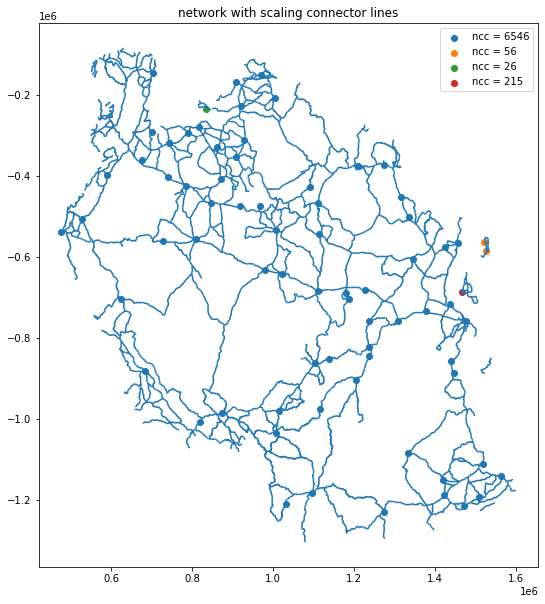

In [19]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
joined_scaled.plot(ax=ax)
for ncc in ccomps_scaled_df.number_connected_components.value_counts().index:
    ccomps_scaled_df[ccomps_scaled_df.number_connected_components==ncc].plot(ax=ax, label=f'ncc = {ncc}')
ax.legend()
ax.set_title('network with scaling connector lines')
plt.show()

## 4.5 Add costs

Now you are ready to assign the costs to paved and unpaved roads.

In [20]:
cost_per_km_paved = 1
cost_per_km_unpaved = 4
print(uun_joined_scaled.transport_type.value_counts())
uun_joined_scaled['cost'] = np.nan
uun_joined_scaled.loc[uun_joined_scaled.transport_type == 'paved', 'cost'] = (uun_joined_scaled.loc[uun_joined_scaled.transport_type == 'paved']
                                                                              .geometry.length/1000)*cost_per_km_paved
uun_joined_scaled.loc[uun_joined_scaled.transport_type == 'unpaved', 'cost'] = (uun_joined_scaled.loc[uun_joined_scaled.transport_type == 'unpaved']
                                                                                .geometry.length/1000)*cost_per_km_unpaved

unpaved    4695
paved      3142
Name: transport_type, dtype: int64


# 5. Find optimal paths between cities

Now that your network is routable, fully connected, and costs are specified, you can solve it!

- Using the roads and cities network created in step 4, solve the network to find the shortest paths
- Once again, you should follow the code we have provided during the lecture on Donaldson and Hornbeck's paper on the American railroad

In [21]:
nw = gdf_to_nx(uun_joined_scaled)
all_costs = nx.shortest_path_length(nw, weight = 'cost')
d = {element[0] : {k: v for k, v in element[1].items() if k in centlist_mod} for element in all_costs if element[0] in centlist_mod}

- Now iterate over the list of centroids to grab the elements from the dictionary and insert them into a list of lists into the right order. 
- Finally, convert the  list of lists into a `pandas` dataframe. 

In [22]:
out = []
for centroid_i in centlist_mod:
    out_centi = []
    distance_dictionary_centroid_i = d[centroid_i]
    for centroid_j in centlist_mod:
        if centroid_j in distance_dictionary_centroid_i:
            out_centi.append(distance_dictionary_centroid_i[centroid_j])
        else:
            out_centi.append(np.nan)
    out.append(out_centi)
cities_names = list(modified_centroids.name)
out = pd.DataFrame(out, index = cities_names, columns = cities_names) 
out

,Arusha,Babati,Bagamoyo,Bariadi,Bukoba,Bunda,Chake Chake,Chalinze,Chato,Dar es Salaam,...,Tabora,Tandahimba,Tanga,Tarime,Tunduru,Urambo,Uyovu,Vwawa,Wete,Zanzibar
Arusha,0.000000,170.006517,945.555029,1032.035362,1031.074512,1082.795359,NaN,897.162286,993.613541,1015.758356,...,639.734659,2088.111849,801.022857,1187.680038,1639.344413,801.221854,794.921953,1302.695346,NaN,NaN
Babati,170.006517,0.000000,1049.527651,862.511688,861.550837,913.271685,NaN,935.824566,824.089866,1076.912709,...,470.210985,2146.158714,957.908409,1018.156363,1469.820738,631.698179,625.398279,1133.171672,NaN,NaN
Bagamoyo,945.555029,1049.527651,0.000000,1602.732573,1601.771722,1653.492570,NaN,114.019161,1564.310751,81.872914,...,1210.431870,1154.226407,285.139027,1758.377248,1242.986488,1371.919064,1365.619164,906.337422,NaN,NaN
Bariadi,1032.035362,862.511688,1602.732573,0.000000,927.122842,105.613963,NaN,1489.029488,889.661871,1630.117631,...,617.111419,2699.363636,1725.459696,210.498641,2023.025660,778.598613,690.970284,1686.376593,NaN,NaN
Bukoba,1031.074512,861.550837,1601.771722,927.122842,0.000000,977.882840,NaN,1488.068638,196.637342,1629.156780,...,616.150568,2698.402785,1724.498846,1082.767518,2022.064810,777.637763,296.975873,1685.415743,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Urambo,801.221854,631.698179,1371.919064,778.598613,777.637763,829.358610,NaN,1258.215980,740.176792,1399.304123,...,161.525087,2468.550127,1494.646188,934.243289,1792.212152,0.000000,541.485205,1455.563085,NaN,NaN
Uyovu,794.921953,625.398279,1365.619164,690.970284,296.975873,741.730281,NaN,1251.916079,208.551276,1393.004222,...,379.998010,2462.250227,1488.346287,846.614960,1785.912251,541.485205,0.000000,1449.263185,NaN,NaN
Vwawa,1302.695346,1133.171672,906.337422,1686.376593,1685.415743,1737.136590,NaN,792.634337,1647.954772,933.722480,...,1294.075891,1693.527260,1029.064545,1842.021269,857.286008,1455.563085,1449.263185,0.000000,NaN,NaN
Wete,NaN,NaN,NaN,NaN,NaN,NaN,90.207111,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


Notice that for this application we would just need the distance of each city to the primary city!

- Create a dataframe having 2 columns: i) city names and ii) distance to primary city.

In [23]:
distance_primary = pd.DataFrame({'distance_primary_city': out['Dar es Salaam']}).reset_index(drop=False)
distance_primary.columns = ['name', 'distance_primary_city']
distance_primary

,name,distance_primary_city
0,Arusha,1015.758356
1,Babati,1076.912709
2,Bagamoyo,81.872914
3,Bariadi,1630.117631
4,Bukoba,1629.156780
...,...,...
69,Urambo,1399.304123
70,Uyovu,1393.004222
71,Vwawa,933.722480
72,Wete,NaN


# 6. Build the final dataset

- The point of this data construction exercise is to build a dataset you can use to run Storeygard's regression.

- You should therefore build this dataset as a final exercise

- The dataset should have
    - city names
    - city populations
    - a column for the year
    - lights in both years
    - oil prices in both years (we have provided the oil price data in `Europe_Brent_Spot_Price_FOB.csv`)
    - distance to the primary city

In [26]:
df92 = lights_cities[['name', 'pop', 'lights92']].copy()
df13 = lights_cities[['name', 'pop', 'lights13']].copy()
df92.columns = ['name', 'pop', 'lights']
df13.columns = ['name', 'pop', 'lights']
df92['year'] = 1992
df13['year'] = 2013
df = pd.concat([df92, df13], axis=0)

oil = pd.read_csv('../data/cleaned/oil/Europe_Brent_Spot_Price_FOB.csv')
oil.columns = ['year', 'oil_price']
df = pd.merge(df, oil, on=['year'], how='left')

df = pd.merge(df, distance_primary, on=['name'], how='inner')

df

,name,pop,lights,year,oil_price,distance_primary_city
0,Bukoba,59147,383.0,1992,19.32,1629.156780
1,Bukoba,59147,872.0,2013,108.56,1629.156780
2,Tarime,29215,56.0,1992,19.32,1785.762306
3,Tarime,29215,276.0,2013,108.56,1785.762306
4,Musoma,104851,497.0,1992,19.32,1741.926708
...,...,...,...,...,...,...
143,Mbinga,15359,244.0,2013,108.56,1221.071465
144,Newala,16910,103.0,1992,19.32,1029.769349
145,Newala,16910,134.0,2013,108.56,1029.769349
146,Tunduru,24512,0.0,1992,19.32,1270.371547
